In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'
path_to_csv_binary = r'/mnt/data/psteinmetz/bb_results.csv'
path_to_csv_binary_40 = r'/mnt/data/psteinmetz/bb_results_40.csv'

In [3]:
data_tumor = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)
data_binary = pd.read_csv(path_to_csv_binary).dropna()

data_binary_40 = pd.read_csv(path_to_csv_binary_40).dropna()

In [4]:
data_tum = pd.concat((data_tumor['Record_ID'], data_tumor.filter(regex='original_shape')), axis=1)

In [5]:
data_tumor = data_tum[['Record_ID', 'original_shape_Elongation', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',  'original_shape_Flatness']]
data_tumor_40 = data_tum[['Record_ID', 'original_shape_Elongation_40.0', 'original_shape_Sphericity_40.0', 'original_shape_SurfaceVolumeRatio_40.0',  'original_shape_Flatness_40.0']]

data_binary = data_binary[data_binary.columns.drop(list(data_binary.filter(regex='original_shape')))]
data_binary_40 = data_binary_40[data_binary_40.columns.drop(list(data_binary_40.filter(regex='original_shape')))]

In [6]:
data_train = pd.merge(data_binary, data_tumor, on='Record_ID')
data_train_40 = pd.merge(data_binary_40, data_tumor_40, on='Record_ID')

In [7]:
data_train = data_train[[i for i in data_train if len(set(data_train[i]))>1]]
data_train_40 = data_train_40[[i for i in data_train_40 if len(set(data_train_40[i]))>1]]

In [8]:
data_train_40.columns.shape

(48,)

In [9]:
data_train.columns.shape

(52,)

In [10]:
X_train = data_train[data_train.columns.drop(['Unnamed: 0', 'Record_ID', 'Shape.1', 'Margins (MR)'])]
y_train = data_train[['Margins (MR)']]

X_train_40 = data_train_40[data_train_40.columns.drop(['Record_ID', 'Shape.1', 'Margins (MR)'])]

In [11]:
y_train.value_counts()

Margins (MR) 
Irregular        72
Spiculated       56
Circunscribed     3
Name: count, dtype: int64

In [12]:
label_encoder = LabelEncoder()
y_train['Margins (MR)']= label_encoder.fit_transform(y_train['Margins (MR)']) 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
y_train

,Margins (MR)
0,1
1,2
2,2
3,1
4,2
...,...
126,2
127,2
128,1
129,1


In [14]:
y_train.value_counts()

Margins (MR)
1               72
2               56
0                3
Name: count, dtype: int64

In [15]:
y_train.loc[y_train['Margins (MR)']==1, 'Margins (MR)'] = 0
y_train.loc[y_train['Margins (MR)']==2, 'Margins (MR)'] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: xlabel='Margins (MR)'>

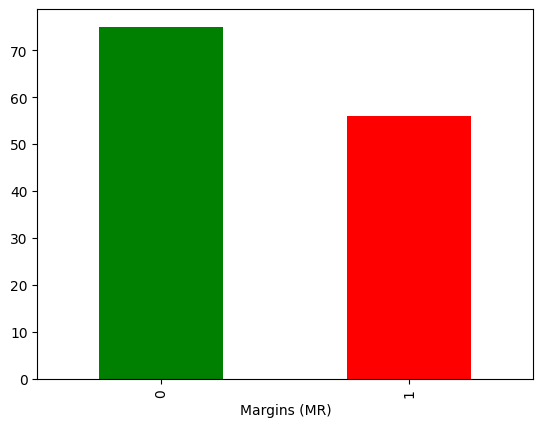

In [16]:
y_train['Margins (MR)'].value_counts().plot.bar(color=['green', 'red'])

In [17]:
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

scaler_40 = StandardScaler()
scaled_X_train_40 = pd.DataFrame(scaler_40.fit_transform(X_train_40), columns=X_train_40.columns)

In [18]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [19]:
y_train.value_counts()

Margins (MR)
0               75
1               56
Name: count, dtype: int64

In [20]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, X):

    coef_dict = {}

    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef

    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [21]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):

    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')

    return color_vals

 
# Visualize coefficients
def visualize_coefs(coef_dict):

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)

    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

    plt.show()

In [22]:
rs = 123

# Grid search hyperparameters for a logistic regression model

def grid_search_lr(X_train, y_train, kfolds):
    params_grid = {
            #'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'penalty': ["l1", "l2"],
            
            'C': np.arange(0.1, 3, 0.1)
                    }

    lr_model = LogisticRegression(random_state=rs, max_iter=1000, solver="liblinear")
    grid_search = GridSearchCV(estimator = lr_model,
                               param_grid = params_grid,
                               scoring='f1',
                               
                               cv = kfolds.split(X_train, y_train), 
                               verbose = 1)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

 

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds):

    params_grid = {
            'max_depth': range(2, 20),
            'n_estimators': [5, 50, 100, 150, 200],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None]#,
            #'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

    }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

def grid_search_xgb(X_train, y_train, kfolds, sample_weight=None):

    params_grid = {
        'max_depth': range(2, 20),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }

    if sample_weight is not None:
        boost_model = XGBClassifier(objective= 'binary:logistic',
                                    nthread=4, 
                                    scale_pos_weight = sample_weight,
                                    random_state=rs)
    else:
        boost_model = XGBClassifier(objective= 'binary:logistic',
                                    nthread=4,
                                    random_state=rs)
    grid_search = GridSearchCV(estimator=boost_model,
                               param_grid=params_grid,
                               scoring = 'f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search


    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    if metric == 'youden_index':
        score = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).mean(), 2)
        std = round((cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score), cv=kfolds) + cross_val_score(model, to_fit, target, scoring=make_scorer(recall_score,pos_label=0), cv=kfolds) -1).std(), 2)
    else:
        score = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean(), 2)
        std = round(cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).std(), 2)

    return score, std

In [23]:
best_params_logreg, grid_search_logreg = grid_search_lr(scaled_X_train, y_train.values.ravel(), skf)
best_params_logreg_40, grid_search_logreg_40 = grid_search_lr(scaled_X_train_40, y_train.values.ravel(), skf)

Fitting 5 folds for each of 58 candidates, totalling 290 fits
Fitting 5 folds for each of 58 candidates, totalling 290 fits


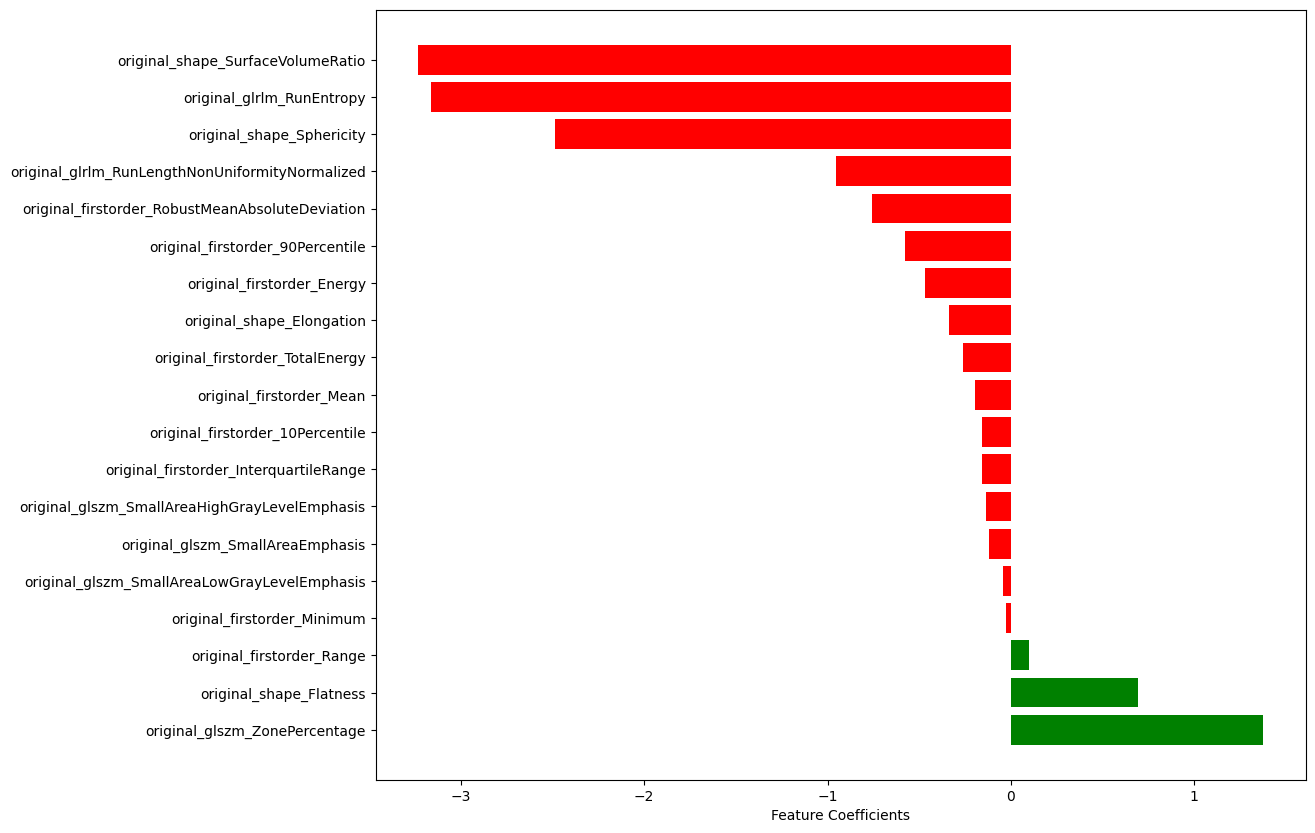

In [24]:
coef_dict = get_feature_coefs(grid_search_logreg.best_estimator_, scaled_X_train)
visualize_coefs(coef_dict)

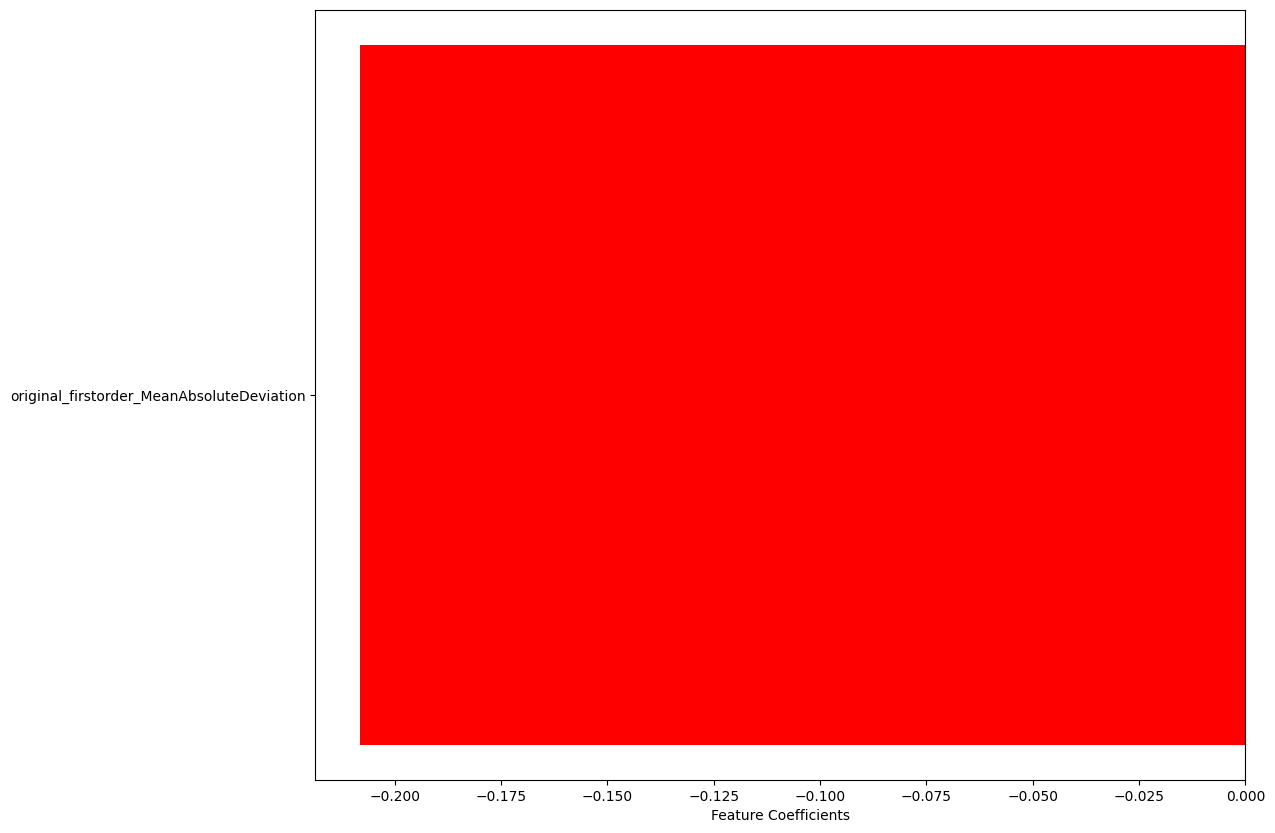

In [25]:
coef_dict = get_feature_coefs(grid_search_logreg_40.best_estimator_, scaled_X_train_40)
visualize_coefs(coef_dict)

In [26]:
background_values_log_reg = shap.maskers.Independent(scaled_X_train, max_samples=100)
# compute SHAP values
explainer_log_reg = shap.Explainer(grid_search_logreg.best_estimator_.predict, background_values_log_reg)
shap_values_log_reg = explainer_log_reg(scaled_X_train)

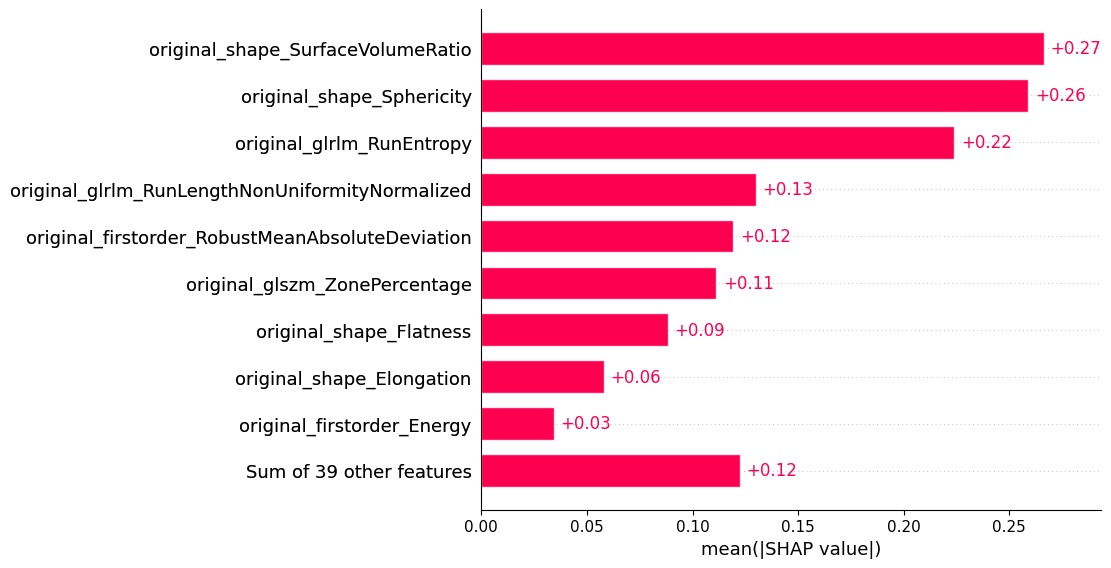

In [27]:
shap.plots.bar(shap_values_log_reg)

In [28]:
background_values_log_reg_40 = shap.maskers.Independent(scaled_X_train_40, max_samples=100)
# compute SHAP values
explainer_log_reg_40 = shap.Explainer(grid_search_logreg_40.best_estimator_.predict, background_values_log_reg_40)
shap_values_log_reg_40 = explainer_log_reg_40(scaled_X_train_40)

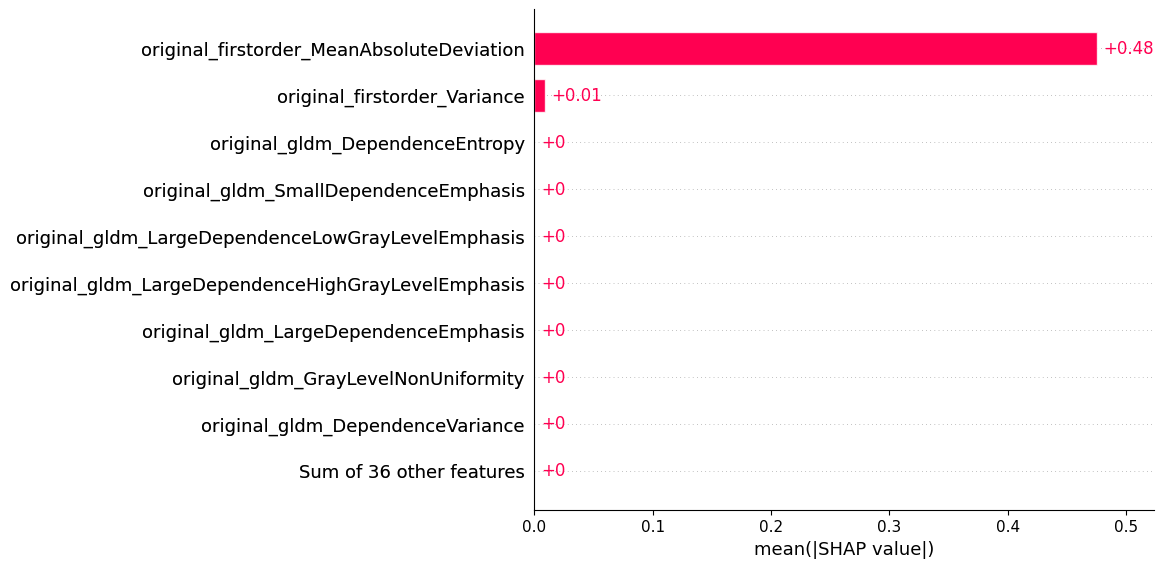

In [29]:
shap.plots.bar(shap_values_log_reg_40)

In [30]:
val_lr = (pd.DataFrame(abs(shap_values_log_reg.values), columns=X_train.columns)).mean(axis=0).sort_values(ascending=False)

In [31]:
val_lr_40 = (pd.DataFrame(abs(shap_values_log_reg_40.values), columns=X_train_40.columns)).mean(axis=0).sort_values(ascending=False)

In [32]:
val_lr_40

original_firstorder_MeanAbsoluteDeviation             0.475458
original_firstorder_Variance                          0.008511
original_firstorder_90Percentile                      0.000000
original_glszm_LargeAreaEmphasis                      0.000000
original_glrlm_RunEntropy                             0.000000
original_glrlm_RunLengthNonUniformity                 0.000000
original_glrlm_RunLengthNonUniformityNormalized       0.000000
original_glrlm_RunPercentage                          0.000000
original_glrlm_RunVariance                            0.000000
original_glrlm_ShortRunEmphasis                       0.000000
original_glrlm_ShortRunHighGrayLevelEmphasis          0.000000
original_glrlm_ShortRunLowGrayLevelEmphasis           0.000000
original_glszm_LargeAreaLowGrayLevelEmphasis          0.000000
original_glszm_LargeAreaHighGrayLevelEmphasis         0.000000
original_glrlm_LongRunHighGrayLevelEmphasis           0.000000
original_glszm_SmallAreaEmphasis                      0

In [33]:
val_lr

original_shape_SurfaceVolumeRatio                     0.266313
original_shape_Sphericity                             0.259099
original_glrlm_RunEntropy                             0.223916
original_glrlm_RunLengthNonUniformityNormalized       0.130130
original_firstorder_RobustMeanAbsoluteDeviation       0.119260
original_glszm_ZonePercentage                         0.111206
original_shape_Flatness                               0.088252
original_shape_Elongation                             0.058053
original_firstorder_Energy                            0.034359
original_firstorder_Mean                              0.033130
original_firstorder_InterquartileRange                0.024237
original_firstorder_TotalEnergy                       0.020504
original_glszm_SmallAreaEmphasis                      0.014580
original_glszm_SmallAreaHighGrayLevelEmphasis         0.013336
original_firstorder_90Percentile                      0.007206
original_glszm_SmallAreaLowGrayLevelEmphasis          0

In [34]:
best_params_logreg_restricted_nb_of_features, grid_search_logreg_restricted_nb_of_features = grid_search_lr(scaled_X_train[val_lr.keys()[:8]], y_train.values.ravel(), skf)
best_params_logreg_restricted_nb_of_features_40, grid_search_logreg_restricted_nb_of_features_40 = grid_search_lr(scaled_X_train_40[val_lr_40.keys()[:2]], y_train.values.ravel(), skf)

Fitting 5 folds for each of 58 candidates, totalling 290 fits


Fitting 5 folds for each of 58 candidates, totalling 290 fits


In [35]:
best_params_rf, grid_search_randomforest = grid_search_rf(X_train, y_train.values.ravel(), skf)
best_params_rf_40, grid_search_randomforest_40 = grid_search_rf(X_train_40, y_train.values.ravel(), skf)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


In [36]:
grid_search_randomforest_40.best_score_

0.6035573122529644

In [37]:
grid_search_randomforest.best_params_

{'max_depth': 4,
 'max_features': 'log2',
 'min_samples_split': 5,
 'n_estimators': 50}

In [38]:
background_values_rf = shap.maskers.Independent(X_train, max_samples=100)
# compute SHAP values
explainer_rf = shap.Explainer(grid_search_randomforest.best_estimator_.predict, background_values_rf)
shap_values_rf = explainer_rf(X_train)

PermutationExplainer explainer: 132it [00:21,  3.23it/s]                         


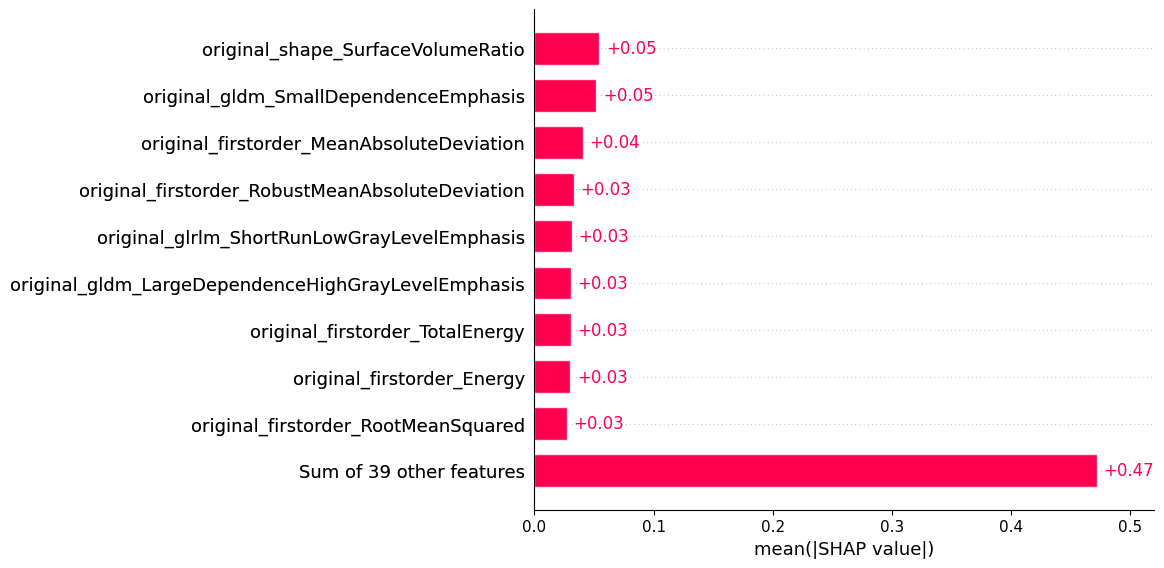

In [39]:
shap.plots.bar(shap_values_rf)

In [40]:
background_values_rf_40 = shap.maskers.Independent(X_train_40, max_samples=100)
# compute SHAP values
explainer_rf_40 = shap.Explainer(grid_search_randomforest_40.best_estimator_.predict, background_values_rf_40)
shap_values_rf_40 = explainer_rf_40(X_train_40)

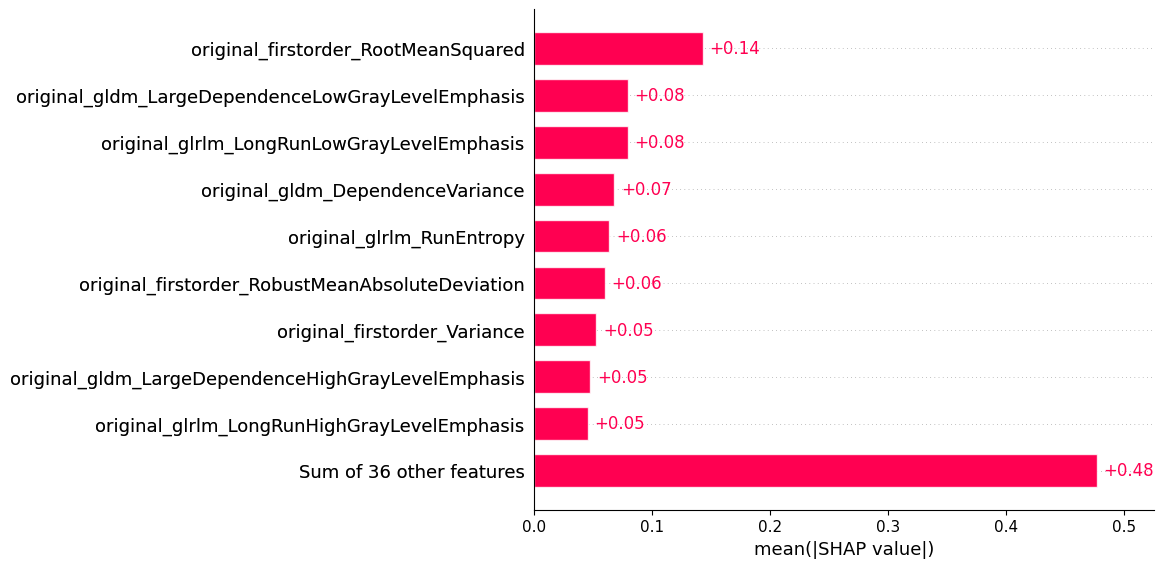

In [41]:
shap.plots.bar(shap_values_rf_40)

In [42]:
val_rf = (pd.DataFrame(abs(shap_values_rf.values), columns=X_train.columns)).mean(axis=0).sort_values(ascending=False)

In [43]:
val_rf_40 = (pd.DataFrame(abs(shap_values_rf_40.values), columns=X_train_40.columns)).mean(axis=0).sort_values(ascending=False)

Text(0.5, 1.0, 'Visualizing Feature Importances')

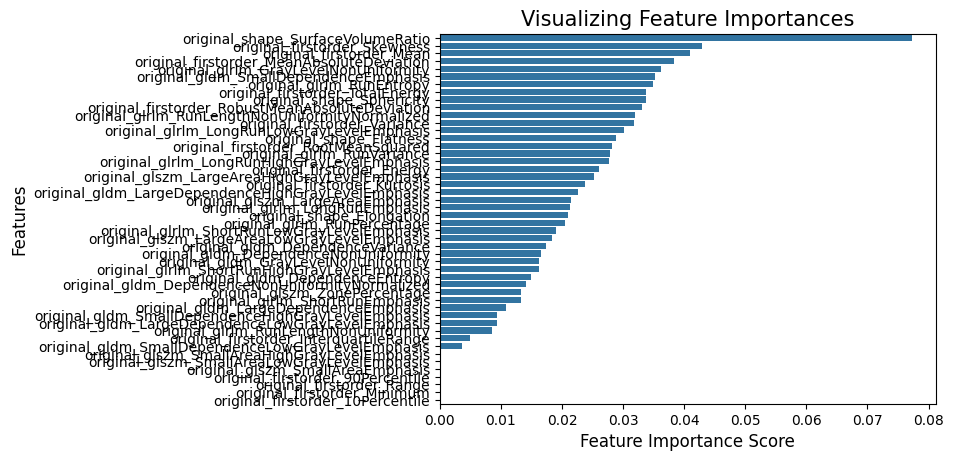

In [44]:
feature_imp = pd.Series(grid_search_randomforest.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp[:], y=feature_imp[:].index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

Text(0.5, 1.0, 'Visualizing Feature Importances')

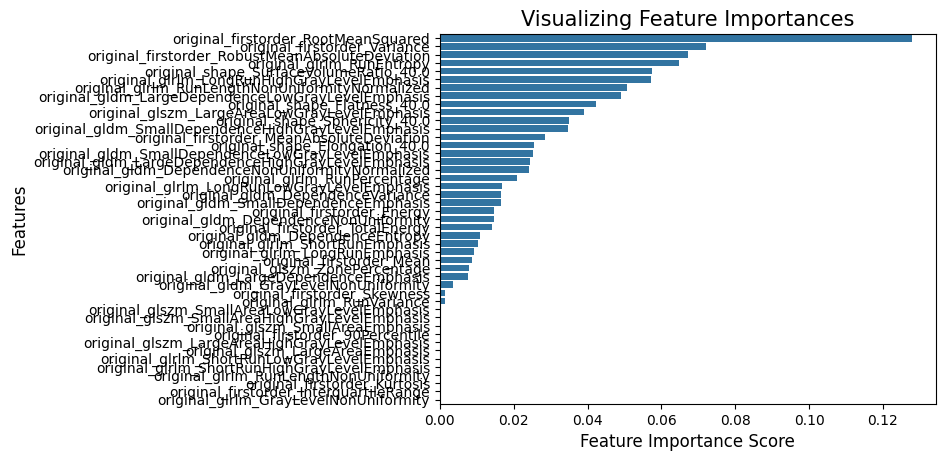

In [45]:
feature_imp_40 = pd.Series(grid_search_randomforest_40.best_estimator_.feature_importances_, index=X_train_40.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_40[:], y=feature_imp_40[:].index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

In [46]:
sum(feature_imp_40[val_rf_40.keys()[:19]])

0.8286307741171327

In [47]:
best_params_rf_restricted_nb_of_features, grid_search_rf_restricted_nb_of_features = grid_search_rf(X_train[val_rf.keys()[:35]], y_train.values.ravel(), skf)
best_params_rf_restricted_nb_of_features_40, grid_search_rf_restricted_nb_of_features_40 = grid_search_rf(X_train_40[val_rf_40.keys()[:19]], y_train.values.ravel(), skf)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


In [48]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]

In [49]:
best_params_xgb, grid_search_xgboost = grid_search_xgb(X_train, y_train.values.ravel(), skf, ratio)
best_params_xgb_40, grid_search_xgboost_40 = grid_search_xgb(X_train_40, y_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [50]:
grid_search_xgboost.best_score_

0.5615643615643616

In [51]:
background_values_xgb = shap.maskers.Independent(X_train, max_samples=100)
# compute SHAP values
explainer_xgb = shap.Explainer(grid_search_xgboost.best_estimator_.predict, background_values_xgb)
shap_values_xgb = explainer_xgb(X_train)

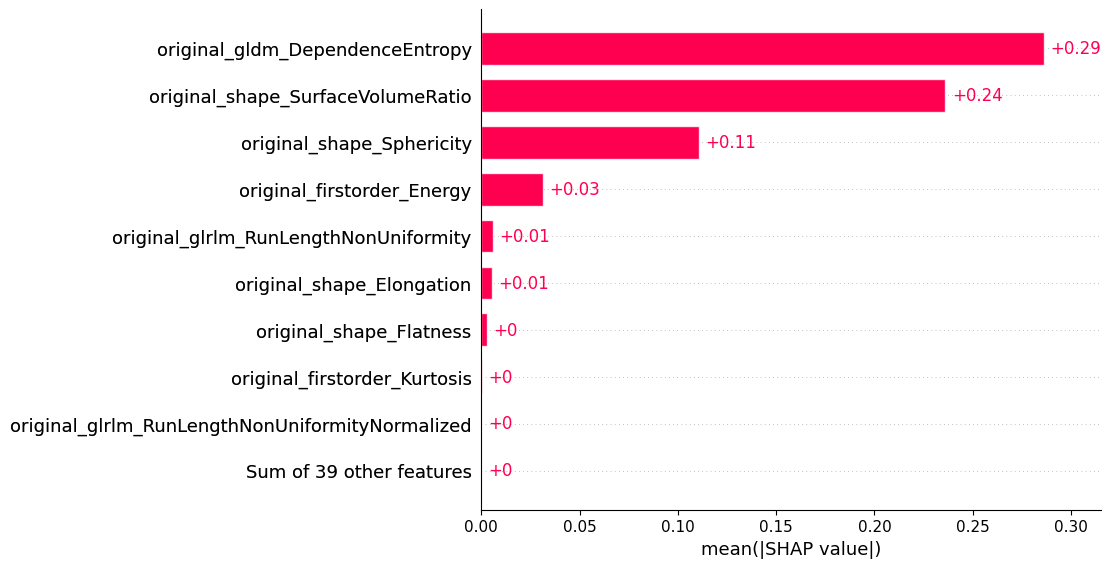

In [52]:
shap.plots.bar(shap_values_xgb)

In [53]:
background_values_xgb_40 = shap.maskers.Independent(X_train_40, max_samples=100)
# compute SHAP values
explainer_xgb_40 = shap.Explainer(grid_search_xgboost_40.best_estimator_.predict, background_values_xgb_40)
shap_values_xgb_40 = explainer_xgb_40(X_train_40)

PermutationExplainer explainer: 132it [00:14,  2.64it/s]                         


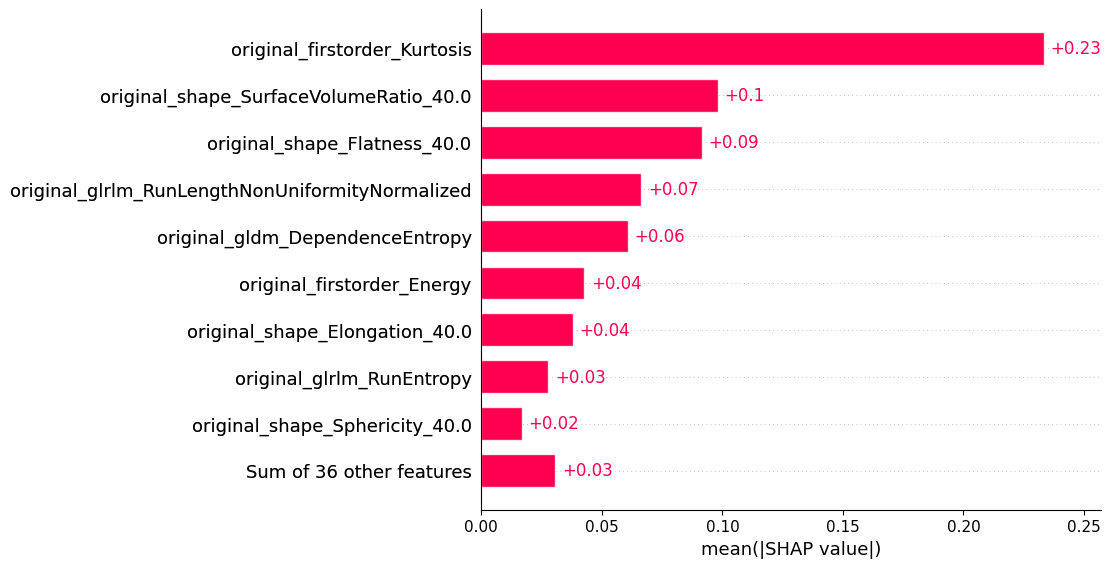

In [54]:
shap.plots.bar(shap_values_xgb_40)

In [55]:
val_xgb = (pd.DataFrame(abs(shap_values_xgb.values), columns=X_train.columns)).mean(axis=0).sort_values(ascending=False)

In [56]:
val_xgb_40 = (pd.DataFrame(abs(shap_values_xgb_40.values), columns=X_train_40.columns)).mean(axis=0).sort_values(ascending=False)

In [57]:
best_params_xgb_restricted_nb_of_features, grid_search_xgb_restricted_nb_of_features = grid_search_xgb(X_train[val_xgb.keys()[:4]], y_train.values.ravel(), skf, ratio)
best_params_xgb_restricted_nb_of_features_40, grid_search_xgb_restricted_nb_of_features_40 = grid_search_xgb(X_train_40[val_xgb_40.keys()[:9]], y_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [58]:
def compile_results(model, X, y, kfolds, return_bool=None):
    
    auc, auc_std = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy, balanced_accuracy_std = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision, precision_std = return_kfold_score(model, X, y, 'precision', kfolds)
    recall, recall_std = return_kfold_score(model, X, y, 'recall', kfolds)
    f1, f1_std = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity, specificity_std = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity, sensitivity_std = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index , youden_index_std = return_kfold_score(model, X, y, 'youden_index', kfolds, 'youden_index')

    if return_bool is None:
        for x in [('auc', auc, auc_std), ('balanced_acc', balanced_accuracy, balanced_accuracy_std), ('precision', precision, precision_std), ('recall', recall, recall_std), ('f1', f1, f1_std), ('specificity', specificity, specificity_std), ('sensitivity', sensitivity, sensitivity_std), ('youden_index', youden_index, youden_index_std)]:       
            print(str(x[0]) + ' ' + str(str(x[1])) + ' +/- ' + str(x[2]))

    if return_bool:

        return [(auc, auc_std), (balanced_accuracy, balanced_accuracy_std), (precision, precision_std), (recall, recall_std), (f1, f1_std), (specificity, specificity_std), (sensitivity, sensitivity_std), (youden_index, youden_index_std)]

In [59]:
comp_results = [compile_results(x, (scaled_X_train if x==grid_search_logreg.best_estimator_ else X_train), y_train.values.ravel(), skf, True) for x in [grid_search_logreg.best_estimator_, grid_search_randomforest.best_estimator_, grid_search_xgboost.best_estimator_]]
results = pd.DataFrame(comp_results, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [60]:
results

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.58, 0.07)","(0.62, 0.08)","(0.62, 0.07)"
balanced_accuracy,"(0.58, 0.07)","(0.67, 0.04)","(0.61, 0.07)"
precision,"(0.55, 0.17)","(0.67, 0.07)","(0.57, 0.11)"
recall,"(0.37, 0.19)","(0.53, 0.07)","(0.57, 0.09)"
f1,"(0.43, 0.17)","(0.59, 0.06)","(0.56, 0.07)"
specificity,"(0.79, 0.11)","(0.8, 0.06)","(0.65, 0.15)"
sensitivity,"(0.37, 0.19)","(0.53, 0.07)","(0.57, 0.09)"
youden_index,"(0.16, 0.15)","(0.33, 0.09)","(0.22, 0.14)"


In [61]:
comp_results_40 = [compile_results(x, (scaled_X_train_40 if x==grid_search_logreg_40.best_estimator_ else X_train_40), y_train.values.ravel(), skf, True) for x in [grid_search_logreg_40.best_estimator_, grid_search_randomforest_40.best_estimator_, grid_search_xgboost_40.best_estimator_]]
results_40 = pd.DataFrame(comp_results_40, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [62]:
results_40

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.65, 0.11)","(0.68, 0.09)","(0.65, 0.04)"
balanced_accuracy,"(0.62, 0.07)","(0.66, 0.06)","(0.64, 0.07)"
precision,"(0.56, 0.1)","(0.62, 0.07)","(0.59, 0.08)"
recall,"(0.55, 0.11)","(0.59, 0.09)","(0.63, 0.18)"
f1,"(0.55, 0.1)","(0.6, 0.08)","(0.59, 0.1)"
specificity,"(0.68, 0.07)","(0.73, 0.04)","(0.65, 0.16)"
sensitivity,"(0.55, 0.11)","(0.59, 0.09)","(0.63, 0.18)"
youden_index,"(0.23, 0.15)","(0.32, 0.12)","(0.28, 0.14)"


In [63]:
comp_results_restricted_nb_of_features = [compile_results(x, (scaled_X_train[val_lr.keys()[:10]] if x==grid_search_logreg_restricted_nb_of_features.best_estimator_ else X_train[val_rf.keys()[:15]] if x==grid_search_rf_restricted_nb_of_features else X_train[val_xgb.keys()[:4]]), y_train.values.ravel(), skf, True) for x in [grid_search_logreg_restricted_nb_of_features.best_estimator_, grid_search_rf_restricted_nb_of_features.best_estimator_, grid_search_xgb_restricted_nb_of_features.best_estimator_]]
results_restricted_nb_of_features = pd.DataFrame(comp_results_restricted_nb_of_features, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [64]:
results_restricted_nb_of_features

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.62, 0.02)","(0.62, 0.07)","(0.65, 0.07)"
balanced_accuracy,"(0.62, 0.07)","(0.59, 0.06)","(0.66, 0.06)"
precision,"(0.64, 0.13)","(0.54, 0.08)","(0.65, 0.11)"
recall,"(0.45, 0.16)","(0.5, 0.12)","(0.55, 0.13)"
f1,"(0.51, 0.11)","(0.51, 0.09)","(0.58, 0.09)"
specificity,"(0.8, 0.11)","(0.68, 0.08)","(0.76, 0.11)"
sensitivity,"(0.45, 0.16)","(0.5, 0.12)","(0.55, 0.13)"
youden_index,"(0.25, 0.14)","(0.18, 0.11)","(0.31, 0.12)"


In [65]:
comp_results_restricted_nb_of_features_40 = [compile_results(x, (scaled_X_train_40[val_lr_40.keys()[:2]] if x==grid_search_logreg_restricted_nb_of_features_40.best_estimator_ else X_train_40[val_rf_40.keys()[:19]] if x==grid_search_rf_restricted_nb_of_features_40 else X_train_40[val_xgb_40.keys()[:9]]), y_train.values.ravel(), skf, True) for x in [grid_search_logreg_restricted_nb_of_features_40.best_estimator_, grid_search_rf_restricted_nb_of_features_40.best_estimator_, grid_search_xgb_restricted_nb_of_features_40.best_estimator_]]
results_restricted_nb_of_features_40 = pd.DataFrame(comp_results_restricted_nb_of_features_40, index=['Logistic Regression', 'Random Forest', 'XG Boost'], columns=['roc_auc', 'balanced_accuracy', 'precision', 'recall', 'f1', 'specificity', 'sensitivity', 'youden_index']).T

In [66]:
results_restricted_nb_of_features_40

,Logistic Regression,Random Forest,XG Boost
roc_auc,"(0.65, 0.11)","(0.66, 0.07)","(0.66, 0.07)"
balanced_accuracy,"(0.62, 0.07)","(0.59, 0.05)","(0.64, 0.09)"
precision,"(0.56, 0.1)","(0.55, 0.09)","(0.59, 0.1)"
recall,"(0.55, 0.11)","(0.5, 0.09)","(0.63, 0.18)"
f1,"(0.55, 0.1)","(0.52, 0.06)","(0.59, 0.1)"
specificity,"(0.68, 0.07)","(0.68, 0.11)","(0.65, 0.14)"
sensitivity,"(0.55, 0.11)","(0.5, 0.09)","(0.63, 0.18)"
youden_index,"(0.23, 0.15)","(0.18, 0.11)","(0.28, 0.17)"
